## ECG Preprocessing Pipeline

### 1. Load Clean Dataset

In [14]:
!pip install scikit-learn==1.5.2 imbalanced-learn==0.12.3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.combine import SMOTETomek
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

file_path = 'missingvaluesdone.csv'
df = pd.read_csv(file_path)
print('Initial shape:', df.shape)
df.head()

Initial shape: (8533, 38)



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


,age,sex,heart_axis,RR_mean,RR_std,HR,QRS_duration,l5_QRS_duration,PR_interval,l5_PR_interval,...,LF_HF_ratio,dominant_freq,spectral_entropy,mean,median,std,skew,kurt,zero_crossings,condition
0,54.0,0,LAD,970.000000,17.029386,61.855670,97.777778,93.200000,191.111111,188.400000,...,0.386047,2.929688,5.650555,-3.530000e-17,-0.153010,1.0,4.241455,25.360262,77.0,Normal
1,48.0,0,LAD,814.363636,15.155393,73.677160,107.500000,92.333333,194.333333,214.166667,...,1.364808,4.882812,5.293184,-1.280000e-17,-0.280783,1.0,2.106691,5.721974,78.0,MI
2,56.0,0,LAD,681.538462,2.499704,88.036117,115.000000,101.000000,196.000000,202.285714,...,1.181564,1.464844,5.117901,-9.950000e-18,0.071950,1.0,0.243890,4.556635,75.0,Normal
3,56.0,0,LAD,962.000000,53.690471,62.370062,95.400000,90.800000,194.600000,173.000000,...,1.816331,0.976562,5.273018,-4.760000e-17,-0.268608,1.0,2.175067,6.217853,78.0,Normal
4,56.0,0,LAD,679.000000,6.129554,88.365243,92.666667,87.466667,203.866667,192.400000,...,0.402798,1.464844,5.489678,-3.550000e-18,0.044945,1.0,0.863977,7.894348,93.0,Normal


### 2. Stratified Sampling on Imbalanced Class

In [15]:
target = 'condition'
y = df[target]
X = df.drop(columns=[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (6826, 37) Test shape: (1707, 37)


### 3. One-Hot Encoding

In [16]:
categorical_cols = ['sex', 'heart_axis']
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

encoded_train = encoder.fit_transform(X_train[categorical_cols])
encoded_test = encoder.transform(X_test[categorical_cols])

encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)

X_train = X_train.drop(columns=categorical_cols).join(encoded_train_df)
X_test = X_test.drop(columns=categorical_cols).join(encoded_test_df)

c:\Users\Hajel\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### 4. Standardization

In [17]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

### 5. Correlation Matrix & Feature Drop

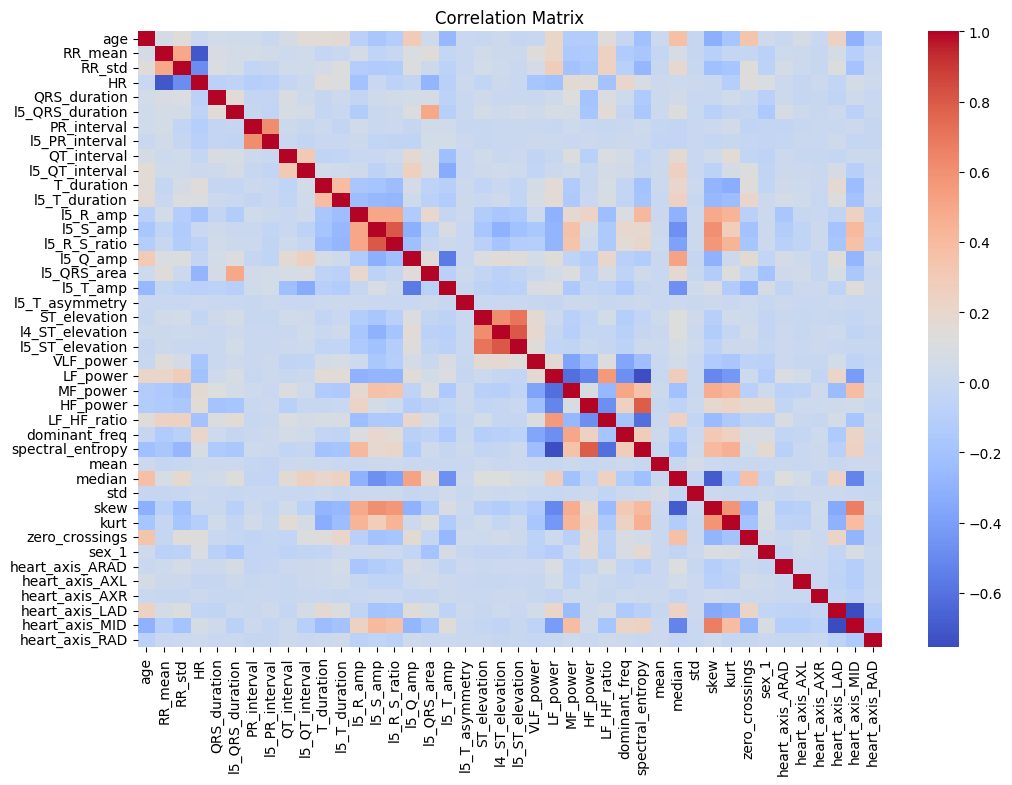

Dropped features: set()


In [18]:
corr_matrix = X_train.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

threshold = 0.9
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            to_drop.add(corr_matrix.columns[i])

X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
print('Dropped features:', to_drop)

from scipy.stats import pointbiserialr


### 6. Outlier Removal

In [19]:
z_scores = np.abs(stats.zscore(X_train))
filtered = (z_scores < 3).all(axis=1)
X_train = X_train[filtered]
y_train = y_train.loc[filtered]
print('Shape after outlier removal:', X_train.shape)

Shape after outlier removal: (4330, 42)


### 7. Balancing with SMOTE + Tomek

In [20]:
smote_tomek = SMOTETomek(random_state=42)
X_train_res, y_train_res = smote_tomek.fit_resample(X_train, y_train)
print('Class balance after SMOTE:', y_train_res.value_counts())

Class balance after SMOTE: condition
CAD       3275
Normal    3269
MI        3269
Name: count, dtype: int64


### 8. Save Preprocessed Datasets

In [ ]:
train_final = pd.DataFrame(X_train_res, columns=X_train.columns)
train_final['condition'] = y_train_res.values

test_final = X_test.copy()
test_final['condition'] = y_test.values

train_final.to_csv('ECG_train_preprocessed.csv', index=False)
test_final.to_csv('ECG_test_preprocessed.csv', index=False)
print('✅ Preprocessed train/test datasets saved.')